In [1]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm

# import tensorflow as tf
# import tensorflow_probability as tfp

import vegas

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# tf.test.is_gpu_available()

In [4]:
# tf.compat.v1.enable_eager_execution()
# print(tf.config.threading.get_inter_op_parallelism_threads())
# print(tf.config.threading.get_intra_op_parallelism_threads())


# tf.compat.v1.disable_eager_execution()
# tf.config.threading.set_inter_op_parallelism_threads(64)
# tf.config.threading.set_intra_op_parallelism_threads(64)

In [5]:
# print(tf.config.threading.get_inter_op_parallelism_threads())
# print(tf.config.threading.get_intra_op_parallelism_threads())

In [6]:
# def start_profiling():
#     stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
#     logdir = 'logs/func/%s' % stamp

#     # Start tracing.                                                                                                                                                                              
#     options = tf.profiler.experimental.ProfilerOptions(
#         host_tracer_level=3, python_tracer_level=1, device_tracer_level=1, delay_ms=None
#     )

#     tf.profiler.experimental.start(logdir, options = options)
#     return logdir
    
    
# def end_profiling():
#     tf.profiler.experimental.stop()

In [7]:
def f1(x):
    """
        https://stackoverflow.com/questions/52774351/how-to-run-parallel-map-fn-when-eager-execution-enabled
    """
    return tf.sin(tf.reduce_sum(x, axis=-1))

In [8]:
ndim = 9
sigma = 0.01
alpha = sigma * np.sqrt(2)

def f2(x):
    pre = tf.cast(1.0 / (alpha * tf.sqrt(np.pi)) ** ndim, dtype=tf.float64)
    exponent = -1 * tf.reduce_sum(x ** 2, axis=-1) / alpha ** 2
    return pre * tf.exp(exponent)

In [9]:
# c1 = tf.random.uniform(shape=(10,6), minval=0, maxval=10, dtype=tf.float64)
# c2 = tf.random.uniform(shape=(2,9), minval=0, maxval=.04, dtype=tf.float64)

In [10]:
# x = tf.compat.v1.placeholder(tf.float64, shape=[None])

# with tf.compat.v1.Session() as sess:

#     #writer = tf.summary.create_file_writer(logdir)

#     #tf.profiler.experimental.start(logdir, options = options)                                                                                                                                
#     #tf.summary.trace_on(graph=True, profiler=True)

#     print(
#         sess.run(
#             f1(c1),
# #             feed_dict={
# #                 x: np.ones(4, dtype=np.int)
# #             }
#         )
#     )

# #f1(c1)

In [9]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [55]:
# try gauss_8d

ndims = 8

sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi

@vegas.batchintegrand
def f1_np(x):
    pre = 1.0 / (alpha * np.sqrt(pi)) ** ndims
    exponent = -1 * np.sum((x - .5) ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)


integ = vegas.Integrator([[0, 1]] * ndims, mpi=False)

current_result = integ(f1_np, nitn=10, neval=2e5)
current_result = integ(f1_np, nitn=10, neval=2e5)

print(current_result.summary())
print('result = %s    Q = %.2f' % (current_result, current_result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.9994(12)      0.9994(12)          0.00     1.00
  2   0.9994(10)      0.99936(79)         0.00     1.00
  3   0.99917(89)     0.99927(59)         0.01     0.99
  4   0.99953(77)     0.99937(47)         0.03     0.99
  5   1.00197(67)     1.00023(38)         2.57     0.04
  6   0.99971(59)     1.00007(32)         2.16     0.06
  7   1.00025(53)     1.00012(28)         1.81     0.09
  8   1.00066(49)     1.00025(24)         1.69     0.11
  9   1.00030(46)     1.00026(21)         1.48     0.16
 10   0.99970(43)     1.00015(19)         1.46     0.15

result = 1.00015(19)    Q = 0.15


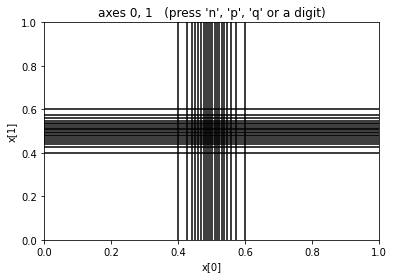

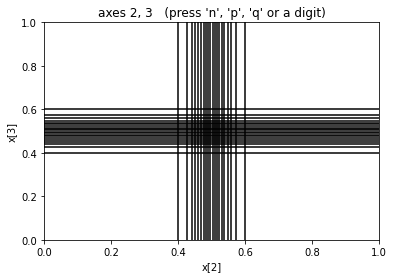

In [62]:
integ.map.show_grid(20, axes=[[0,1]])
integ.map.show_grid(20, axes=[[2,3]])

In [63]:
# try triple_gauss_8d

ndims = 8

sigma = 0.05
alpha = sigma * np.sqrt(2)
pi = np.pi

norm_m1, norm_m2, norm_m3 = 0.33, 0.47, 0.67

@vegas.batchintegrand
def f2_np(x):
    pre = 1. / (alpha * np.sqrt(pi)) ** ndims
    exponent1 = -1. * np.sum(((x - norm_m1) ** 2), axis=-1) / alpha ** 2
    exponent2 = -1. * np.sum(((x - norm_m2) ** 2), axis=-1) / alpha ** 2
    exponent3 = -1. * np.sum(((x - norm_m3) ** 2), axis=-1) / alpha ** 2
    return pre / 3 * (np.exp(exponent1) + np.exp(exponent2) + np.exp(exponent3))


integ = vegas.Integrator([[0, 1]] * ndims, mpi=False)

current_result = integ(f2_np, nitn=10, neval=2e5)
current_result = integ(f2_np, nitn=10, neval=2e5)

print(current_result.summary())
print('result = %s    Q = %.2f' % (current_result, current_result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.971(11)       0.971(11)           0.00     1.00
  2   0.9798(97)      0.9760(73)          0.35     0.55
  3   0.9819(69)      0.9791(50)          0.34     0.71
  4   0.9657(71)      0.9746(41)          1.02     0.38
  5   0.9698(71)      0.9734(36)          0.85     0.49
  6   0.9719(76)      0.9731(32)          0.69     0.63
  7   1.081(76)       0.9733(32)          0.91     0.49
  8   1.020(30)       0.9739(32)          1.12     0.35
  9   0.9892(76)      0.9762(30)          1.41     0.19
 10   0.9878(77)      0.9776(28)          1.47     0.15

result = 0.9776(28)    Q = 0.15


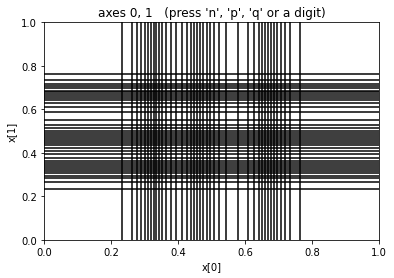

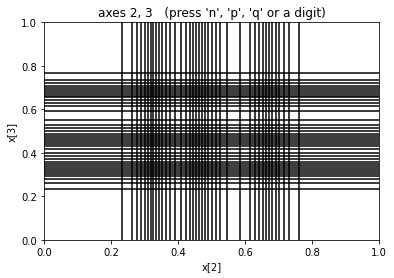

In [65]:
integ.map.show_grid(40, axes=[[0,1]])
integ.map.show_grid(40, axes=[[2,3]])

In [77]:
vegas.Integrator?

In [101]:
# try sin_8d

ndims = 4



class TestClass():
    
    def __init__(self):
        self.ncalls_counter = 0

    @vegas.batchintegrand
    def f3_np(self, x):
        self.ncalls_counter += 1
        return np.sin(np.sum(x, axis=-1))


integ = vegas.Integrator([[0, 10]] * ndims, mpi=False,
                         nhcube_batch=1000*20000,
                         max_nhcube=1e9,
                         max_neval_hcube=1e6*10000,
                         max_mem=2e9
                        )


bb = TestClass()

integ(bb.f3_np, nitn=10, neval=2e7)
current_result = integ(bb.f3_np, nitn=10, neval=2e7)

print(current_result.summary())
print('result = %s    Q = %.2f' % (current_result, current_result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   12.26(22)       12.26(22)           0.00     1.00
  2   12.54(22)       12.40(16)           0.82     0.37
  3   12.21(22)       12.34(13)           0.65     0.52
  4   12.82(22)       12.46(11)           1.63     0.18
  5   12.71(22)       12.510(99)          1.49     0.20
  6   12.30(22)       12.475(90)          1.35     0.24
  7   12.38(22)       12.461(83)          1.15     0.33
  8   12.70(22)       12.491(78)          1.14     0.34
  9   12.20(22)       12.459(74)          1.19     0.30
 10   12.26(22)       12.439(70)          1.14     0.33

result = 12.439(70)    Q = 0.33


In [87]:
print(bb.ncalls_counter)

62


In [ ]:
# try sin_8d

ndims = 4



class TestClass():
    
    def __init__(self):
        self.ncalls_counter = 0

    @vegas.batchintegrand
    def f3_np(self, x):
        self.ncalls_counter += 1
        return np.sin(np.sum(x, axis=-1))


integ = vegas.Integrator([[0, 10]] * ndims, mpi=False, nhcube_batch=5_000_000)


bb = TestClass()

integ(bb.f3_np, nitn=10, neval=2e8)
current_result = integ(bb.f3_np, nitn=10, neval=2e8)

print(current_result.summary())
print('result = %s    Q = %.2f' % (current_result, current_result.Q))

### F1

In [12]:
target = 128 * (np.cos(5) + np.cos(15) + np.cos(25)) * np.sin(5) **7

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(-49.165073816419444, 0.001)

#### Simple

In [24]:
def f1(x):
    return np.sin(np.sum(x, axis=-1))

In [25]:
ndims = 6

In [26]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e4, 1e5, 1e6]))
run_lst = list(range(1,11))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        integ = vegas.Integrator([[0, 10]] * ndims, mpi=False)
        current_result = integ(f1, nitn=10, neval=neval)
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        results_nevals_used.append(current_result.sum_neval)
        print(f'- {current_result.sum_neval}\n')

        #current_result_mean = tf.reduce_mean(current_result).numpy()
        #current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result.mean)
        results_stddevs.append(current_result.sdev)
        results.append(current_result)

run=1 neval=10000
- 89413.0

run=1 neval=100000
- 943687.0

run=1 neval=1000000
- 9279982.0

run=2 neval=10000
- 89385.0

run=2 neval=100000
- 943929.0

run=2 neval=1000000
- 9279609.0

run=3 neval=10000
- 89399.0

run=3 neval=100000
- 943943.0

run=3 neval=1000000
- 9280271.0

run=4 neval=10000
- 89372.0

run=4 neval=100000
- 943801.0

run=4 neval=1000000
- 9279638.0

run=5 neval=10000
- 89374.0

run=5 neval=100000
- 943947.0

run=5 neval=1000000
- 9279573.0

run=6 neval=10000
- 89394.0

run=6 neval=100000
- 943989.0

run=6 neval=1000000
- 9280308.0

run=7 neval=10000
- 89364.0

run=7 neval=100000
- 943743.0

run=7 neval=1000000
- 9279950.0

run=8 neval=10000
- 89360.0

run=8 neval=100000
- 944077.0

run=8 neval=1000000
- 9280053.0

run=9 neval=10000
- 89313.0

run=9 neval=100000
- 943895.0

run=9 neval=1000000
- 9279925.0

run=10 neval=10000
- 89394.0

run=10 neval=100000
- 943895.0

run=10 neval=1000000
- 9279785.0



In [27]:
temp_df = pd.DataFrame({'neval': neval_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'results_nevals_used': results_nevals_used,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [28]:
temp_df

,neval,result_means,results_stddevs,results_nevals_used,result_times,run,s_per_sample
0,10000,-667.343862,2379.915093,89413.0,0.580447,1,0.000006
1,100000,676.329742,697.777805,943687.0,6.008923,1,0.000006
2,1000000,-58.677959,188.600756,9279982.0,58.912385,1,0.000006
3,10000,2217.599709,2376.269501,89385.0,0.577456,2,0.000006
4,100000,-1365.761603,697.433384,943929.0,6.011915,2,0.000006
5,1000000,161.171006,188.707142,9279609.0,58.575287,2,0.000006
6,10000,-1999.056595,2380.704784,89399.0,0.574463,3,0.000006
7,100000,226.485428,697.182933,943943.0,5.978007,3,0.000006
8,1000000,-159.439159,188.626218,9280271.0,59.351337,3,0.000006
9,10000,936.703662,2376.560995,89372.0,0.590440,4,0.000007


In [29]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

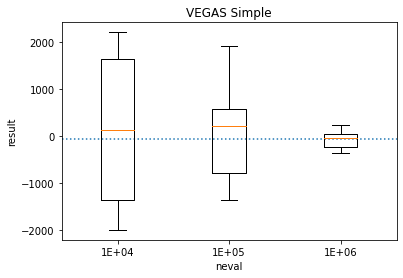

In [30]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Simple')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [31]:
temp_df.groupby('neval')['result_means'].agg([np.mean, np.std])

,mean,std
neval,,
10000,148.934403,1653.540322
100000,96.816519,1040.818306
1000000,-61.126373,191.449978


In [32]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

-11.961298940414494

In [33]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

neval
10000       0.577064
100000      6.024989
1000000    58.794583
Name: result_times, dtype: float64

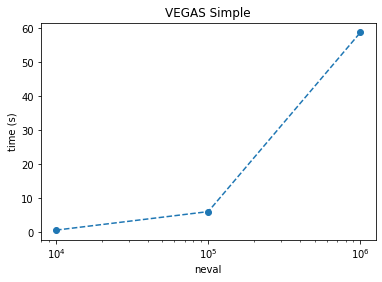

In [34]:
plt.title('VEGAS Simple')
plt.xlabel('neval')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### Precompute

In [35]:
def f1(x):
    return np.sin(np.sum(x, axis=-1))

In [36]:
ndims = 6

In [37]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e4, 1e5, 1e6]))
run_lst = list(range(1,11))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        integ = vegas.Integrator([[0, 10]] * ndims, mpi=False)
        
        # precompute on 100% of nitn*neval
        integ(f1, nitn=10, neval=neval)
        
        current_result = integ(f1, nitn=10, neval=neval, adapt=False)
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        results_nevals_used.append(current_result.sum_neval)
        print(f'- {current_result.sum_neval}\n')

        #current_result_mean = tf.reduce_mean(current_result).numpy()
        #current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result.mean)
        results_stddevs.append(current_result.sdev)
        results.append(current_result)

run=1 neval=10000
- 89630.0

run=1 neval=100000
- 937550.0

run=1 neval=1000000
- 9267130.0

run=2 neval=10000
- 89540.0

run=2 neval=100000
- 937750.0

run=2 neval=1000000
- 9265000.0

run=3 neval=10000
- 89510.0

run=3 neval=100000
- 937390.0

run=3 neval=1000000
- 9265420.0

run=4 neval=10000
- 89800.0

run=4 neval=100000
- 937590.0

run=4 neval=1000000
- 9265640.0

run=5 neval=10000
- 89620.0

run=5 neval=100000
- 937800.0

run=5 neval=1000000
- 9265350.0

run=6 neval=10000
- 89540.0

run=6 neval=100000
- 938120.0

run=6 neval=1000000
- 9264580.0

run=7 neval=10000
- 89500.0

run=7 neval=100000
- 936820.0

run=7 neval=1000000
- 9266990.0

run=8 neval=10000
- 89780.0

run=8 neval=100000
- 937870.0

run=8 neval=1000000
- 9264250.0

run=9 neval=10000
- 89730.0

run=9 neval=100000
- 937470.0

run=9 neval=1000000
- 9265990.0

run=10 neval=10000
- 89550.0

run=10 neval=100000
- 937360.0

run=10 neval=1000000
- 9265970.0



In [38]:
temp_df = pd.DataFrame({'neval': neval_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'results_nevals_used': results_nevals_used,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [39]:
temp_df

,neval,result_means,results_stddevs,results_nevals_used,result_times,run,s_per_sample
0,10000,527.078154,2374.104281,89630.0,1.153427,1,0.000013
1,100000,1254.855042,701.100685,937550.0,11.930215,1,0.000013
2,1000000,-312.905799,189.157869,9267130.0,117.164514,1,0.000013
3,10000,-1082.312439,2376.191728,89540.0,1.131981,2,0.000013
4,100000,649.984730,701.603483,937750.0,11.954666,2,0.000013
5,1000000,-55.038064,189.221194,9265000.0,117.905084,2,0.000013
6,10000,-5359.943085,2379.877399,89510.0,1.145944,3,0.000013
7,100000,-647.913671,701.665226,937390.0,11.934287,3,0.000013
8,1000000,184.804677,189.144250,9265420.0,117.690540,3,0.000013
9,10000,1858.112759,2377.797522,89800.0,1.139466,4,0.000013


In [40]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

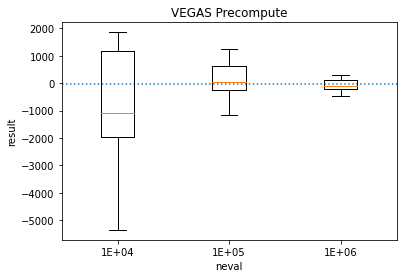

In [41]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Precompute')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [42]:
temp_df.groupby('neval')['result_means'].agg([np.mean, np.std])

,mean,std
neval,,
10000,-940.635698,2329.135425
100000,121.380185,731.647782
1000000,-74.420418,235.782802


In [43]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

-25.255343849977713

In [44]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

neval
10000        1.145148
100000      11.972703
1000000    117.819212
Name: result_times, dtype: float64

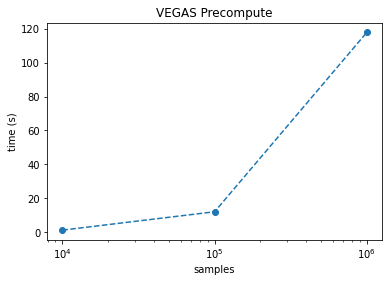

In [45]:
plt.title('VEGAS Precompute')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### Batch

In [46]:
@vegas.batchintegrand
def f1(x):
    return np.sin(np.sum(x, axis=-1))

In [47]:
ndims = 6

In [48]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []

result_runs = []
result_neval = []
result_nhcube_batch = []

nhcube_batch_list = list(map(int, [1e4]))
neval_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,11))


for run in run_lst:
    for neval in neval_lst:
        for nhcube_batch in nhcube_batch_list:
        
            print(f'run={run} neval={neval} nhcube_batch_list={nhcube_batch}')

            time_a = time.time()
            integ = vegas.Integrator([[0, 10]] * ndims, mpi=False, nhcube_batch=nhcube_batch)

            # precompute on 100% of nitn*neval
            integ(f1, nitn=10, neval=neval)

            current_result = integ(f1, nitn=10, neval=neval)
            time_b = time.time() - time_a
            result_times.append(time_b)
            
            result_runs.append(run)
            result_neval.append(neval)
            result_nhcube_batch.append(nhcube_batch)

            results_nevals_used.append(current_result.sum_neval)
            print(f'- {current_result.sum_neval}\n')

            #current_result_mean = tf.reduce_mean(current_result).numpy()
            #current_result_stddev = tf.math.reduce_std(current_result).numpy()

            results_means.append(current_result.mean)
            results_stddevs.append(current_result.sdev)
            results.append(current_result)

run=1 neval=100000 nhcube_batch_list=10000
- 943866.0

run=1 neval=1000000 nhcube_batch_list=10000
- 9280029.0

run=1 neval=10000000 nhcube_batch_list=10000
- 93519003.0

run=2 neval=100000 nhcube_batch_list=10000
- 943775.0

run=2 neval=1000000 nhcube_batch_list=10000
- 9279451.0

run=2 neval=10000000 nhcube_batch_list=10000
- 93514491.0

run=3 neval=100000 nhcube_batch_list=10000
- 943843.0

run=3 neval=1000000 nhcube_batch_list=10000
- 9279122.0

run=3 neval=10000000 nhcube_batch_list=10000
- 93516311.0

run=4 neval=100000 nhcube_batch_list=10000
- 943760.0

run=4 neval=1000000 nhcube_batch_list=10000
- 9279888.0

run=4 neval=10000000 nhcube_batch_list=10000
- 93515222.0

run=5 neval=100000 nhcube_batch_list=10000
- 943986.0

run=5 neval=1000000 nhcube_batch_list=10000
- 9280522.0

run=5 neval=10000000 nhcube_batch_list=10000
- 93516001.0

run=6 neval=100000 nhcube_batch_list=10000
- 943687.0

run=6 neval=1000000 nhcube_batch_list=10000
- 9279678.0

run=6 neval=10000000 nhcube_batch

In [49]:
temp_df = pd.DataFrame({'neval': result_neval,
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'results_nevals_used': results_nevals_used,
                        'result_times': result_times,
                        'run': result_runs,
                        'nhcube_batch': result_nhcube_batch
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [50]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

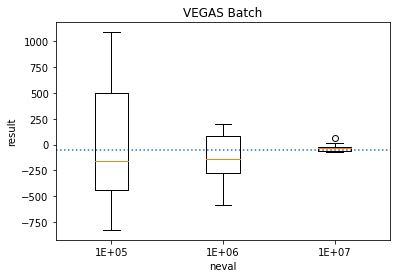

In [51]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Batch')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [52]:
temp_df.groupby(['neval', 'nhcube_batch'])['result_means'].agg([np.mean, np.std])

,,mean,std
neval,nhcube_batch,,
100000,10000,-18.262191,656.545054
1000000,10000,-133.936960,248.010680
10000000,10000,-31.359089,42.940403


In [53]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

17.805985054526232

In [54]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

neval
100000       0.299898
1000000      2.849975
10000000    28.564079
Name: result_times, dtype: float64

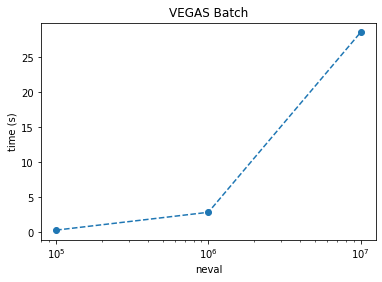

In [55]:
plt.title('VEGAS Batch')
plt.xlabel('neval')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### BatchParallel

In [94]:
import multiprocessing
import numpy as np
import vegas


class parallelintegrand(vegas.BatchIntegrand):
    """ Convert (batch) integrand into multiprocessor integrand.

    Integrand should return a numpy array.
    """
    def __init__(self, fcn, nproc=4):
        " Save integrand; create pool of nproc processes. "
        self.fcn = fcn
        self.nproc = nproc
        self.pool = multiprocessing.Pool(processes=nproc)
    def __del__(self):
        " Standard cleanup. "
        self.pool.close()
        self.pool.join()
    def __call__(self, x):
        " Divide x into self.nproc chunks, feeding one to each process. "
        nx = x.shape[0] // self.nproc + 1
        # launch evaluation of self.fcn for each chunk, in parallel
        results = self.pool.map(
            self.fcn,
            [x[i*nx : (i+1)*nx] for i in range(self.nproc)],
            1,
            )
        # convert list of results into a single numpy array
        return np.concatenate(results)

In [95]:
def f1(x):
    return np.sin(np.sum(x, axis=-1))

In [96]:
f1_batch_parallel = parallelintegrand(f1, 4)

In [97]:
ndims = 6

In [98]:
# np.random.seed(123)

# results = []
# results_means = []
# results_stddevs = []
# results_nevals_used = []
# result_times = []
# result_runs = []

# neval_lst = list(map(int, [1e4, 1e5]))
# run_lst = list(range(1,3))


# for run in run_lst:
#     for neval in neval_lst:
        
#         print(f'run={run} neval={neval}')
        
#         time_a = time.time()
#         integ = vegas.Integrator([[0, 10]] * ndims, mpi=False, nhcube_batch=1e3)
        
#         # precompute on 10% of nitn*neval
#         # integ(f1, nitn=10, neval=1e5)
        
#         current_result = integ(f1_batch_parallel, nitn=10, neval=neval)
#         time_b = time.time() - time_a
#         result_times.append(time_b)
#         result_runs.append(run)
        
#         results_nevals_used.append(current_result.sum_neval)
#         print(f'- {current_result.sum_neval - acc_neval}\n')

#         #current_result_mean = tf.reduce_mean(current_result).numpy()
#         #current_result_stddev = tf.math.reduce_std(current_result).numpy()

#         results_means.append(current_result.mean)
#         results_stddevs.append(current_result.sdev)
#         results.append(current_result)

### F2

In [80]:
target = 1

precision = 1e-3
target_precision = min(abs(precision * target), precision)

target, target_precision

(1, 0.001)

#### Simple

In [56]:
ndim = 9
sigma = 0.01
alpha = sigma * np.sqrt(2)

def f2(x):
    pre = 1.0 / (alpha * np.sqrt(np.pi)) ** ndim
    exponent = -1 * np.sum(x ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [57]:
ndims = 9

In [60]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,6))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        integ = vegas.Integrator([[-1, 1]] * ndims, mpi=False)
        current_result = integ(f2, nitn=10, neval=neval)
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        results_nevals_used.append(current_result.sum_neval)
        print(f'- {current_result.sum_neval}\n')

        #current_result_mean = tf.reduce_mean(current_result).numpy()
        #current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result.mean)
        results_stddevs.append(current_result.sdev)
        results.append(current_result)

run=1 neval=100000
- 244944.0

run=1 neval=1000000
- 2875392.0

run=2 neval=100000
- 244944.0

run=2 neval=1000000
- 9624032.0

run=3 neval=100000
- 244944.0

run=3 neval=1000000
- 2875392.0

run=4 neval=100000
- 244944.0

run=4 neval=1000000
- 2875392.0

run=5 neval=100000
- 244944.0

run=5 neval=1000000
- 2875392.0



In [61]:
temp_df = pd.DataFrame({'neval': neval_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'results_nevals_used': results_nevals_used,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [62]:
temp_df

,neval,result_means,results_stddevs,results_nevals_used,result_times,run,s_per_sample
0,100000,0.000000e+00,1.000000e-129,244944.0,2.610017,1,0.000011
1,1000000,1.151546e-174,1.000000e-129,2875392.0,30.335839,1,0.000011
2,100000,0.000000e+00,1.000000e-129,244944.0,2.602038,2,0.000011
3,1000000,7.891003e-140,3.162278e-129,9624032.0,100.149287,2,0.000010
4,100000,0.000000e+00,1.000000e-129,244944.0,2.653444,3,0.000011
5,1000000,4.791707e-180,1.000000e-129,2875392.0,31.179042,3,0.000011
6,100000,4.513385e-219,1.000000e-129,244944.0,2.652933,4,0.000011
7,1000000,1.200649e-291,1.000000e-129,2875392.0,31.128104,4,0.000011
8,100000,0.000000e+00,1.000000e-129,244944.0,2.670899,5,0.000011
9,1000000,8.069308e-299,1.000000e-129,2875392.0,31.150569,5,0.000011


In [63]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

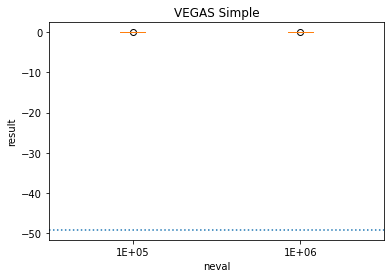

In [64]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Simple')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [65]:
temp_df.groupby('neval')['result_means'].agg([np.mean, np.std])

,mean,std
neval,,
100000,9.026770e-220,0.000000e+00
1000000,1.578201e-140,3.528964e-140


In [79]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

49.165073816419444

In [67]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

neval
100000      2.637866
1000000    44.788568
Name: result_times, dtype: float64

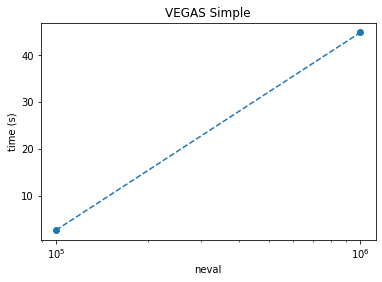

In [68]:
plt.title('VEGAS Simple')
plt.xlabel('neval')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### Precompute

In [69]:
ndims = 9
sigma = 0.01
alpha = sigma * np.sqrt(2)

def f2(x):
    pre = 1.0 / (alpha * np.sqrt(np.pi)) ** ndims
    exponent = -1 * np.sum(x ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [70]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []
result_runs = []

neval_lst = list(map(int, [1e5, 1e6]))
run_lst = list(range(1,6))


for run in run_lst:
    for neval in neval_lst:
        
        print(f'run={run} neval={neval}')
                
        time_a = time.time()
        integ = vegas.Integrator([[-1, 1]] * ndims, mpi=False)
        
        # precompute on 100% of nitn*neval
        integ(f2, nitn=10, neval=neval)
        
        current_result = integ(f2, nitn=10, neval=neval, adapt=False)
        time_b = time.time() - time_a
        result_times.append(time_b)
        result_runs.append(run)
        
        results_nevals_used.append(current_result.sum_neval)
        print(f'- {current_result.sum_neval}\n')

        #current_result_mean = tf.reduce_mean(current_result).numpy()
        #current_result_stddev = tf.math.reduce_std(current_result).numpy()

        results_means.append(current_result.mean)
        results_stddevs.append(current_result.sdev)
        results.append(current_result)

run=1 neval=100000
- 174960.0

run=1 neval=1000000
- 2211840.0

run=2 neval=100000
- 174960.0

run=2 neval=1000000
- 2211840.0

run=3 neval=100000
- 174960.0

run=3 neval=1000000
- 2211840.0

run=4 neval=100000
- 174960.0

run=4 neval=1000000
- 2211840.0

run=5 neval=100000
- 174960.0

run=5 neval=1000000
- 2211840.0



In [81]:
temp_df = pd.DataFrame({'neval': neval_lst * len(run_lst),
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'results_nevals_used': results_nevals_used,
                        'result_times': result_times,
                        'run': result_runs
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [82]:
temp_df

,neval,result_means,results_stddevs,results_nevals_used,result_times,run,s_per_sample
0,100000,0.000000e+00,1.000000e-129,174960.0,4.567351,1,0.000026
1,1000000,2.491238e-246,1.000000e-129,2211840.0,54.905530,1,0.000025
2,100000,0.000000e+00,1.000000e-129,174960.0,4.523897,2,0.000026
3,1000000,7.517211e-289,1.000000e-129,2211840.0,53.831977,2,0.000024
4,100000,0.000000e+00,1.000000e-129,174960.0,4.455081,3,0.000025
5,1000000,1.211620e-271,1.000000e-129,2211840.0,53.694345,3,0.000024
6,100000,0.000000e+00,1.000000e-129,174960.0,4.468046,4,0.000026
7,1000000,5.269302e-203,1.000000e-129,2211840.0,53.761167,4,0.000024
8,100000,3.704032e-169,1.000000e-129,174960.0,4.416185,5,0.000025
9,1000000,3.380918e-272,1.000000e-129,2211840.0,53.784105,5,0.000024


In [83]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

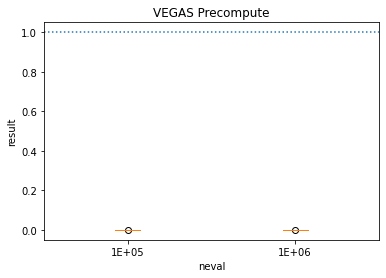

In [84]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Precompute')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [85]:
temp_df.groupby('neval')['result_means'].agg([np.mean, np.std])

,mean,std
neval,,
100000,7.408064e-170,0.0
1000000,1.053860e-203,0.0


In [86]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

-1.0

In [87]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

neval
100000      4.486112
1000000    53.995425
Name: result_times, dtype: float64

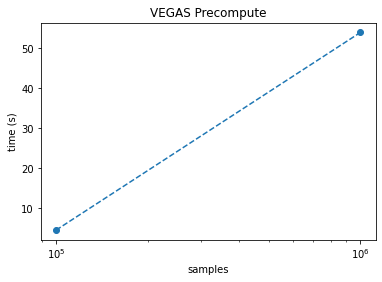

In [88]:
plt.title('VEGAS Precompute')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### Batch

In [89]:
ndims = 9
sigma = 0.01
alpha = sigma * np.sqrt(2)

@vegas.batchintegrand
def f2(x):
    pre = 1.0 / (alpha * np.sqrt(np.pi)) ** ndims
    exponent = -1 * np.sum(x ** 2, axis=-1) / alpha ** 2
    return pre * np.exp(exponent)

In [90]:
np.random.seed(123)

results = []
results_means = []
results_stddevs = []
results_nevals_used = []
result_times = []

result_runs = []
result_neval = []
result_nhcube_batch = []

nhcube_batch_list = list(map(int, [1e4]))
neval_lst = list(map(int, [1e5, 1e6, 1e7]))
run_lst = list(range(1,6))


for run in run_lst:
    for neval in neval_lst:
        for nhcube_batch in nhcube_batch_list:
        
            print(f'run={run} neval={neval} nhcube_batch_list={nhcube_batch}')

            time_a = time.time()
            integ = vegas.Integrator([[-1, 1]] * ndims, mpi=False, nhcube_batch=nhcube_batch)

            # precompute on 100% of nitn*neval
            integ(f2, nitn=10, neval=neval)

            current_result = integ(f2, nitn=10, neval=neval, adapt=False)
            time_b = time.time() - time_a
            result_times.append(time_b)
            
            result_runs.append(run)
            result_neval.append(neval)
            result_nhcube_batch.append(nhcube_batch)

            results_nevals_used.append(current_result.sum_neval)
            print(f'- {current_result.sum_neval}\n')

            #current_result_mean = tf.reduce_mean(current_result).numpy()
            #current_result_stddev = tf.math.reduce_std(current_result).numpy()

            results_means.append(current_result.mean)
            results_stddevs.append(current_result.sdev)
            results.append(current_result)

run=1 neval=100000 nhcube_batch_list=10000
- 174960.0

run=1 neval=1000000 nhcube_batch_list=10000
- 2211840.0

run=1 neval=10000000 nhcube_batch_list=10000
- 95370200.0

run=2 neval=100000 nhcube_batch_list=10000
- 174960.0

run=2 neval=1000000 nhcube_batch_list=10000
- 2211840.0

run=2 neval=10000000 nhcube_batch_list=10000
- 95135580.0

run=3 neval=100000 nhcube_batch_list=10000
- 174960.0

run=3 neval=1000000 nhcube_batch_list=10000
- 9368160.0

run=3 neval=10000000 nhcube_batch_list=10000
- 99147700.0

run=4 neval=100000 nhcube_batch_list=10000
- 174960.0

run=4 neval=1000000 nhcube_batch_list=10000
- 2211840.0

run=4 neval=10000000 nhcube_batch_list=10000
- 98954150.0

run=5 neval=100000 nhcube_batch_list=10000
- 174960.0

run=5 neval=1000000 nhcube_batch_list=10000
- 2211840.0

run=5 neval=10000000 nhcube_batch_list=10000
- 94589740.0



In [91]:
temp_df = pd.DataFrame({'neval': result_neval,
                        'result_means': results_means,
                        'results_stddevs': results_stddevs,
                        'results_nevals_used': results_nevals_used,
                        'result_times': result_times,
                        'run': result_runs,
                        'nhcube_batch': result_nhcube_batch
                       })
temp_df['s_per_sample'] = temp_df.result_times / temp_df.results_nevals_used

In [92]:
temp_df

,neval,result_means,results_stddevs,results_nevals_used,result_times,run,nhcube_batch,s_per_sample
0,100000,0.000000e+00,1.000000e-129,174960.0,0.206447,1,10000,1.179968e-06
1,1000000,2.491238e-246,1.000000e-129,2211840.0,2.349713,1,10000,1.062334e-06
2,10000000,9.997671e-01,1.640091e-04,95370200.0,66.113120,1,10000,6.932262e-07
3,100000,0.000000e+00,1.000000e-129,174960.0,0.206448,2,10000,1.179972e-06
4,1000000,9.433929e-273,1.000000e-129,2211840.0,2.390604,2,10000,1.080821e-06
5,10000000,1.000195e+00,1.275598e-04,95135580.0,65.897696,2,10000,6.926714e-07
6,100000,0.000000e+00,1.000000e-129,174960.0,0.206448,3,10000,1.179972e-06
7,1000000,1.001819e+00,1.208216e-03,9368160.0,7.602659,3,10000,8.115424e-07
8,10000000,1.003193e+00,2.653132e-03,99147700.0,57.916555,3,10000,5.841442e-07
9,100000,0.000000e+00,1.000000e-129,174960.0,0.217418,4,10000,1.242675e-06


In [93]:
g = temp_df.groupby('neval')['result_means'].apply(lambda x: x.tolist())

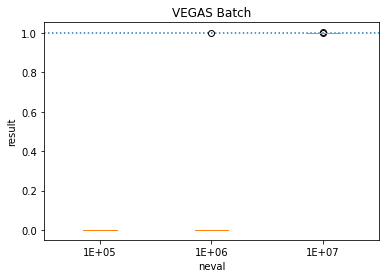

In [94]:
# plt.yscale('log')
plt.axhline(y=target, linestyle=':')
plt.title('VEGAS Batch')
plt.xlabel('neval')
plt.ylabel('result')
plt.boxplot(g.values, labels=[f'{x:.0E}' for x in neval_lst]);

In [99]:
temp_df.groupby(['neval', 'nhcube_batch'])['result_means'].agg([np.mean, np.std])

,,mean,std
neval,nhcube_batch,,
100000,10000,0.000000,0.000000
1000000,10000,0.200364,0.448027
10000000,10000,1.000326,0.001755


In [100]:
temp_df.groupby('neval')['result_means'].agg(np.mean).iloc[-1] - target

0.00032610290997348024

In [101]:
g = temp_df.groupby('neval')['result_times'].apply(lambda x: x.tolist())
g.apply(np.mean)

neval
100000       0.210038
1000000      3.404491
10000000    62.408134
Name: result_times, dtype: float64

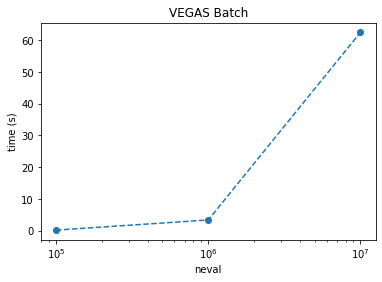

In [102]:
plt.title('VEGAS Batch')
plt.xlabel('neval')
plt.ylabel('time (s)')
plt.scatter(g.index, g.apply(np.mean))
plt.plot(g.index, g.apply(np.mean), linestyle='--')
plt.xscale('log')

#### BatchParallel

In [94]:
import multiprocessing
import numpy as np
import vegas


class parallelintegrand(vegas.BatchIntegrand):
    """ Convert (batch) integrand into multiprocessor integrand.

    Integrand should return a numpy array.
    """
    def __init__(self, fcn, nproc=4):
        " Save integrand; create pool of nproc processes. "
        self.fcn = fcn
        self.nproc = nproc
        self.pool = multiprocessing.Pool(processes=nproc)
    def __del__(self):
        " Standard cleanup. "
        self.pool.close()
        self.pool.join()
    def __call__(self, x):
        " Divide x into self.nproc chunks, feeding one to each process. "
        nx = x.shape[0] // self.nproc + 1
        # launch evaluation of self.fcn for each chunk, in parallel
        results = self.pool.map(
            self.fcn,
            [x[i*nx : (i+1)*nx] for i in range(self.nproc)],
            1,
            )
        # convert list of results into a single numpy array
        return np.concatenate(results)

In [95]:
def f1(x):
    return np.sin(np.sum(x, axis=-1))

In [96]:
f1_batch_parallel = parallelintegrand(f1, 4)

In [97]:
ndims = 6

In [98]:
# np.random.seed(123)

# results = []
# results_means = []
# results_stddevs = []
# results_nevals_used = []
# result_times = []
# result_runs = []

# neval_lst = list(map(int, [1e4, 1e5]))
# run_lst = list(range(1,3))


# for run in run_lst:
#     for neval in neval_lst:
        
#         print(f'run={run} neval={neval}')
        
#         time_a = time.time()
#         integ = vegas.Integrator([[0, 10]] * ndims, mpi=False, nhcube_batch=1e3)
        
#         # precompute on 10% of nitn*neval
#         # integ(f1, nitn=10, neval=1e5)
        
#         current_result = integ(f1_batch_parallel, nitn=10, neval=neval)
#         time_b = time.time() - time_a
#         result_times.append(time_b)
#         result_runs.append(run)
        
#         results_nevals_used.append(current_result.sum_neval)
#         print(f'- {current_result.sum_neval - acc_neval}\n')

#         #current_result_mean = tf.reduce_mean(current_result).numpy()
#         #current_result_stddev = tf.math.reduce_std(current_result).numpy()

#         results_means.append(current_result.mean)
#         results_stddevs.append(current_result.sdev)
#         results.append(current_result)